# Introduction to Neural Networking in Keras

<a href="https://colab.research.google.com/github/coding-dojo-data-science/week-11-lecture-1-intro-to-deep-learning/blob/11.7.22/SOLUTIONS%20Code-along%20Intro%20to%20Neural%20Networking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will use the version of Keras that comes in the Tensorflow package, as it has the most up to date tools.

Keras works as weapper for deep learning model to be used as classification or regression estimators in sklearn

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from seaborn import heatmap

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, \
precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay, \
classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# new libraries
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense

# Set random seeds for consistent outcomes
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

### Plot History

Since we will be plotting histories for all of our models, lets create a function to do it quickly.

In [2]:
def plot_history(history):
  """Takes a keras model learning history and plots each metric"""
  
  metrics = history.history.keys()
  
  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()
        
def eval_regression(true, pred, name='Model'):
    """Evaluates true and predicted values from a regression model.  
    Outputs a dataframe of metrics"""
    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['RMSE'] = [np.sqrt(mean_squared_error(true, pred))]
    scores['MAE'] = [mean_absolute_error(true, pred)]
    scores['R2'] = [r2_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores

def eval_classification(true, pred, name='Model', labels=None):
    """shows classification_report and confusion matrix
    for classification model predictions.  Outputs a dataframe of metrics"""
  
    print(name, '\n')
    print(classification_report(true, pred, target_names=labels))
    ConfusionMatrixDisplay.from_predictions(true, pred, display_labels=labels)
    plt.show()

    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['Precision'] = [precision_score(true, pred)]
    scores['Recall'] = [recall_score(true, pred)]
    scores['F1 Score'] = [f1_score(true, pred)]
    scores['Accuracy'] = [accuracy_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores

# Data

We will be working with 2 different datasets in this project, 1 is a regression dataset and the other is a classification dataset.  This way you can practice doing both using deep learning.

**NOTE**

These datasets are very small for deep learning.  Deep learning models usually work best with very large datasets with at least 10,000 or more samples.  They work best on even larger datasets than that.  But, for demonstration we will use these smaller datasets.

## Regression
This is a dataset of housing prices in Boston from 1978.  Each row is a house and the dataset includes several features regarding each house.  Our target today will be the price of the home.



In [3]:
regression_df = pd.read_csv('https://raw.githubusercontent.com/ninja-josh/image-storage/main/Boston_Housing_from_Sklearn.csv')

# Regression

Let's start with modeling the regression dataset

In [4]:
regression_df

,CRIM,NOX,RM,AGE,PTRATIO,LSTAT,PRICE
0,0.00632,0.538,6.575,65.2,15.3,4.98,24.0
1,0.02731,0.469,6.421,78.9,17.8,9.14,21.6
2,0.02729,0.469,7.185,61.1,17.8,4.03,34.7
3,0.03237,0.458,6.998,45.8,18.7,2.94,33.4
4,0.06905,0.458,7.147,54.2,18.7,5.33,36.2
...,...,...,...,...,...,...,...
501,0.06263,0.573,6.593,69.1,21.0,9.67,22.4
502,0.04527,0.573,6.120,76.7,21.0,9.08,20.6
503,0.06076,0.573,6.976,91.0,21.0,5.64,23.9
504,0.10959,0.573,6.794,89.3,21.0,6.48,22.0


In [5]:
regression_df.duplicated().any()

False

In [6]:
regression_df.describe()

,CRIM,NOX,RM,AGE,PTRATIO,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,0.554695,6.284634,68.574901,18.455534,12.653063,22.532806
std,8.601545,0.115878,0.702617,28.148861,2.164946,7.141062,9.197104
min,0.006320,0.385000,3.561000,2.900000,12.600000,1.730000,5.000000
25%,0.082045,0.449000,5.885500,45.025000,17.400000,6.950000,17.025000
50%,0.256510,0.538000,6.208500,77.500000,19.050000,11.360000,21.200000
75%,3.677083,0.624000,6.623500,94.075000,20.200000,16.955000,25.000000
max,88.976200,0.871000,8.780000,100.000000,22.000000,37.970000,50.000000


In [7]:
# Define X and Y and complete the train test split
X = regression_df.drop(columns = 'PRICE')
y = regression_df['PRICE']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

## Scaling

Always scale your data for deep learning.  Otherwise you get a problem call 'Exploding Weights'.  Some weights will be updated much faster than others because the inputs are at larger scales.  This tends to hurt learning as data on smaller scales does not update as fast and doesn't get to contribute as much to the decision making process.  By scaling we put all features on the same footing.

In [8]:
# Scale the data
scaler = MinMaxScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## First Simple Model

We always want to start simple, as deep learning models can get very complex fast and more complex models take more time to train and are more prone to overfitting.  A well performing simple model is better than a well performing complex model.

## Input layer
The first layer we will define is not technically the input layer.  We will define the first hidden layer with a special argument that tells Keras how to create a input layer:

`input_dim=`

Input layers can also be defined manually using tensorflow.keras.layers.InputLayer

## Activation function

For the single hidden layer we will try just 3 nodes and use a ReLU activation.  ReLUs tend to perform well for hidden nodes.

## Output Layer

For out output layer (last layer) we just use one node because we only want the output of the model to be one number.  We will use a linear activation function.  This will simply output the value from the weights and bias in the node with no change.  The output will be a continuous number, a float.  This will make our model a regression model.




In [9]:
# Check the shape of input

X_train.shape[1]

6

In [10]:
# Set Random Seeds
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Instantiate your sequential model

reg_model = Sequential()
# use all features as input using input_dim
input_dim = X_train.shape[1]

# Add first hidden layer
reg_model.add(Dense(10, activation='relu', input_dim=input_dim, name='h1'))
reg_model.add(Dense(10, activation='relu', name='h2'))
# Add output layer with 1 node
reg_model.add(Dense(1, activation='linear', name ='output'))


# Check summary of network 
reg_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 10)                70        
                                                                 
 h2 (Dense)                  (None, 10)                110       
                                                                 
 output (Dense)              (None, 1)                 11        
                                                                 
Total params: 191
Trainable params: 191
Non-trainable params: 0
_________________________________________________________________


## Compiling

Compiling the model puts all the pieces together to make it ready to train.  We need to specify:

* **Optimizer:** An Adam optimizer is a favorite and often performs well, it's a good place to start.
  - Other optimizers : Gradient Descent,Stochastic Gradient Descent,Adagrad,RMSProp
* **Loss Function:** 'mse' or mean squared error.  This is the number our model will try to reduce in each epoch.  Since this is a regression model we want our model to minimize the mean squared error.
* **Metrics:** 'mae' or mean absolute error.  We can provide a list of any appropriate metrics we want the model to keep track at each epoch.




In [11]:
from tensorflow.keras.metrics import RootMeanSquaredError

In [12]:
# Compile your model.
rmse = RootMeanSquaredError(name='rmse')

reg_model.compile(optimizer= 'adam', loss = 'mse', metrics= ['mae', rmse])

# Training

Let's try training our model for 100 few epochs.  Sometimes that is enough, and it will give us an idea whether our model is learning anything.

In [13]:
# Fit your model

history = reg_model.fit(X_train, y_train,
                        validation_data = (X_test, y_test),
                        epochs = 100)


Epoch 1/100
12/12 [==============================] - 1s 14ms/step - loss: 637.9385 - mae: 23.4772 - rmse: 25.2574 - val_loss: 545.4421 - val_mae: 21.8481 - val_rmse: 23.3547
Epoch 2/100
12/12 [==============================] - 0s 4ms/step - loss: 627.7363 - mae: 23.2455 - rmse: 25.0547 - val_loss: 536.7000 - val_mae: 21.6346 - val_rmse: 23.1668
Epoch 3/100
12/12 [==============================] - 0s 4ms/step - loss: 619.5906 - mae: 23.0577 - rmse: 24.8916 - val_loss: 530.1462 - val_mae: 21.4729 - val_rmse: 23.0249
Epoch 4/100
12/12 [==============================] - 0s 4ms/step - loss: 613.4154 - mae: 22.9153 - rmse: 24.7672 - val_loss: 525.1688 - val_mae: 21.3489 - val_rmse: 22.9166
Epoch 5/100
12/12 [==============================] - 0s 4ms/step - loss: 608.6833 - mae: 22.8066 - rmse: 24.6715 - val_loss: 521.3896 - val_mae: 21.2550 - val_rmse: 22.8340
Epoch 6/100
12/12 [==============================] - 0s 4ms/step - loss: 604.8318 - mae: 22.7205 - rmse: 24.5933 - val_loss: 518.1599 

12/12 [==============================] - 0s 4ms/step - loss: 120.5082 - mae: 8.5656 - rmse: 10.9776 - val_loss: 102.9504 - val_mae: 7.7474 - val_rmse: 10.1464
Epoch 49/100
12/12 [==============================] - 0s 4ms/step - loss: 118.8187 - mae: 8.4998 - rmse: 10.9004 - val_loss: 101.6471 - val_mae: 7.6971 - val_rmse: 10.0820
Epoch 50/100
12/12 [==============================] - 0s 4ms/step - loss: 117.0324 - mae: 8.4296 - rmse: 10.8181 - val_loss: 100.0166 - val_mae: 7.6293 - val_rmse: 10.0008
Epoch 51/100
12/12 [==============================] - 0s 4ms/step - loss: 115.0529 - mae: 8.3477 - rmse: 10.7263 - val_loss: 98.1660 - val_mae: 7.5478 - val_rmse: 9.9079
Epoch 52/100
12/12 [==============================] - 0s 4ms/step - loss: 112.9904 - mae: 8.2566 - rmse: 10.6297 - val_loss: 96.0697 - val_mae: 7.4525 - val_rmse: 9.8015
Epoch 53/100
12/12 [==============================] - 0s 4ms/step - loss: 110.5211 - mae: 8.1428 - rmse: 10.5129 - val_loss: 93.5034 - val_mae: 7.3260 - val_

Epoch 97/100
12/12 [==============================] - 0s 4ms/step - loss: 32.4992 - mae: 4.0425 - rmse: 5.7008 - val_loss: 31.6271 - val_mae: 3.8755 - val_rmse: 5.6238
Epoch 98/100
12/12 [==============================] - 0s 5ms/step - loss: 32.1247 - mae: 4.0151 - rmse: 5.6679 - val_loss: 31.3002 - val_mae: 3.8195 - val_rmse: 5.5947
Epoch 99/100
12/12 [==============================] - 0s 4ms/step - loss: 31.9323 - mae: 4.0000 - rmse: 5.6509 - val_loss: 31.1882 - val_mae: 3.8263 - val_rmse: 5.5846
Epoch 100/100
12/12 [==============================] - 0s 4ms/step - loss: 31.6665 - mae: 3.9564 - rmse: 5.6273 - val_loss: 30.9481 - val_mae: 3.7717 - val_rmse: 5.5631


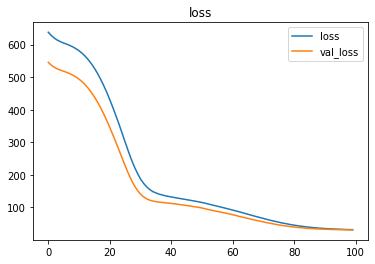

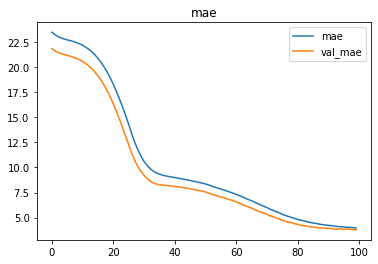

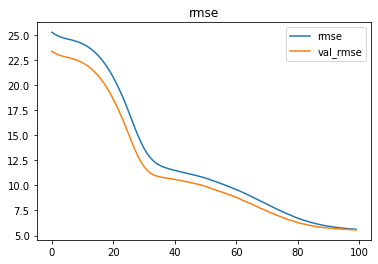

In [14]:
# Apply the custom function to see how your model is doing
plot_history(history)

## Evaluation


In [15]:
# Make predictions and evaluate your model
train_preds = reg_model.predict(X_train)
test_preds = reg_model.predict(X_test)

train_scores = eval_regression(y_train, train_preds, name='base_reg_train')
test_scores = eval_regression(y_test, test_preds, name='base_reg_test')

reg_scores = pd.concat([train_scores, test_scores])
reg_scores

,RMSE,MAE,R2
Model Name,,,
base_reg_train,5.605992,3.939426,0.645619
base_reg_test,5.563101,3.771664,0.558056


# <center> Temperature Check: </center>
## How confident do you feel in coding neural networks?
0. What is a neural net?
1. I know what a neural net is, but I wouldn't know how to start coding it.
2. I kinda get how the code works, but need help from someone else to create my own.
3. I understand the general idea, but would need a full example in front of me.
4. I feel confident in coding a neural network with some reference materials.
5. Move over, Josh.  I can finish this code-along.


# Classification:

Classification models are similar, except that we need to adjust:
* The final activation of the output layer, and
* the loss function and metrics in the compile step.

We will also need to do some 

### Remember: 
MAE, MSE, RMSE, and R2 are regression metrics,

accuracy, recall, precision, and F1-Score are classification metrics.

## Classification Dataset
The classification dataset describes diabetes rates among Pima Indians.  Each row is a person and this dataset includes features regarding health related measurements.  The target is binary and represents whether or not a person will diagnosed with diabetes.  This is another old dataset first presented in 1988.



In [16]:
classification_df = pd.read_csv('https://raw.githubusercontent.com/ninja-josh/image-storage/main/diabetes.csv')
classification_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [17]:
classification_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [18]:
classification_df.duplicated().any()

False

In [19]:
classification_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


We see minimums for Glucose, BloodPression, SkinThickness, Insulin, and BMI of 0s.  Those are impossible for humans, so lets drop those rows.

In [20]:
no_glucose = classification_df['Glucose'] == 0
no_blood = classification_df['BloodPressure'] == 0
no_skin = classification_df['SkinThickness'] == 0
no_insulin = classification_df['Insulin'] == 0
no_bmi = classification_df['BMI'] == 0

#class_df_clean excludes rows that have no values == 0 in the above columns
class_df_clean = classification_df[~(no_glucose |
                                     no_blood |
                                     no_skin |
                                     no_insulin |
                                     no_bmi)]
class_df_clean.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,3.301020,122.627551,70.663265,29.145408,156.056122,33.086224,0.523046,30.864796,0.331633
std,3.211424,30.860781,12.496092,10.516424,118.841690,7.027659,0.345488,10.200777,0.471401
min,0.000000,56.000000,24.000000,7.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,21.000000,76.750000,28.400000,0.269750,23.000000,0.000000
50%,2.000000,119.000000,70.000000,29.000000,125.500000,33.200000,0.449500,27.000000,0.000000
75%,5.000000,143.000000,78.000000,37.000000,190.000000,37.100000,0.687000,36.000000,1.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


We lost a lot of data, going from 768 samples to 392 samples.  In the future we might impute this data using means, medians, or other imputation strategies.  For this exercise we won't focus on that.

In [21]:
# Define X and y and train test split
X = class_df_clean.drop(columns = 'Outcome')
y = class_df_clean['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [22]:
# Scale the data
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Build the Classification Model

We need to do a few things differently here because this is a binary classification:

1. The activation of our final layer needs to be 'sigmoid'.  


(If this were multiclass classification, we would set the final activation as 'softmax' and the number of output nodes would be the number of classes in our y_train.)

In [23]:
# Set random seeds
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Build your model

class_model = Sequential()
class_model.add(Dense(10, activation= 'relu', input_dim=X_train.shape[1]))
class_model.add(Dense(5, activation= 'relu'))
class_model.add(Dense(2, activation= 'relu'))

# One output node with 'sigmoid' activation
class_model.add(Dense(1, activation='sigmoid'))
class_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                90        
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________


## More Changes for Classification:

1.  We need to change our loss to 'binary_crossentropy'.  If this were multiclass we would use 'categorical_crossentrobpy'.

2. Our metrics should be classification metrics.  We will use accuracy.  We could also use recall or precision. 

In [24]:
from tensorflow.keras.metrics import Precision, Recall

In [25]:
# # Compile your model, set metrics = ['acc']
precision = Precision(name='precision')
recall = Recall(name='recall')
class_model.compile(optimizer = 'adam', loss = 'bce', 
                    metrics = ['accuracy', precision, recall]) 


In [26]:
# fit your model
history = class_model.fit(X_train, y_train,
                        validation_data = (X_test, y_test),
                        epochs = 300, verbose =1)

Epoch 1/300
10/10 [==============================] - 1s 30ms/step - loss: 0.6924 - accuracy: 0.6667 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6916 - val_accuracy: 0.6735 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/300
10/10 [==============================] - 0s 7ms/step - loss: 0.6906 - accuracy: 0.6667 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6884 - val_accuracy: 0.6735 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/300
10/10 [==============================] - 0s 7ms/step - loss: 0.6875 - accuracy: 0.6667 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6839 - val_accuracy: 0.6735 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/300
10/10 [==============================] - 0s 6ms/step - loss: 0.6838 - accuracy: 0.6667 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6800 - val_accuracy: 0.6735 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/300
10/10 [========================

10/10 [==============================] - 0s 6ms/step - loss: 0.5756 - accuracy: 0.6667 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5739 - val_accuracy: 0.6735 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 36/300
10/10 [==============================] - 0s 6ms/step - loss: 0.5723 - accuracy: 0.6667 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5708 - val_accuracy: 0.6735 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 37/300
10/10 [==============================] - 0s 7ms/step - loss: 0.5700 - accuracy: 0.6667 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5684 - val_accuracy: 0.6735 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 38/300
10/10 [==============================] - 0s 7ms/step - loss: 0.5657 - accuracy: 0.6667 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5682 - val_accuracy: 0.6735 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 39/300
10/10 [==============================] -

10/10 [==============================] - 0s 6ms/step - loss: 0.4993 - accuracy: 0.6667 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5286 - val_accuracy: 0.6735 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 70/300
10/10 [==============================] - 0s 6ms/step - loss: 0.4972 - accuracy: 0.6667 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5290 - val_accuracy: 0.6735 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 71/300
10/10 [==============================] - 0s 6ms/step - loss: 0.4953 - accuracy: 0.6667 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5282 - val_accuracy: 0.6735 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 72/300
10/10 [==============================] - 0s 6ms/step - loss: 0.4935 - accuracy: 0.6667 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5289 - val_accuracy: 0.6735 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 73/300
10/10 [==============================] -

10/10 [==============================] - 0s 7ms/step - loss: 0.4578 - accuracy: 0.7925 - precision: 0.7176 - recall: 0.6224 - val_loss: 0.5211 - val_accuracy: 0.7551 - val_precision: 0.6250 - val_recall: 0.6250
Epoch 105/300
10/10 [==============================] - 0s 7ms/step - loss: 0.4580 - accuracy: 0.7891 - precision: 0.7093 - recall: 0.6224 - val_loss: 0.5205 - val_accuracy: 0.7143 - val_precision: 0.5556 - val_recall: 0.6250
Epoch 106/300
10/10 [==============================] - 0s 6ms/step - loss: 0.4572 - accuracy: 0.7925 - precision: 0.7033 - recall: 0.6531 - val_loss: 0.5200 - val_accuracy: 0.7143 - val_precision: 0.5556 - val_recall: 0.6250
Epoch 107/300
10/10 [==============================] - 0s 6ms/step - loss: 0.4554 - accuracy: 0.7925 - precision: 0.7079 - recall: 0.6429 - val_loss: 0.5207 - val_accuracy: 0.7347 - val_precision: 0.5882 - val_recall: 0.6250
Epoch 108/300
10/10 [==============================] - 0s 7ms/step - loss: 0.4549 - accuracy: 0.7857 - precision: 

10/10 [==============================] - 0s 7ms/step - loss: 0.4374 - accuracy: 0.8061 - precision: 0.6990 - recall: 0.7347 - val_loss: 0.5192 - val_accuracy: 0.7245 - val_precision: 0.5676 - val_recall: 0.6562
Epoch 141/300
10/10 [==============================] - 0s 6ms/step - loss: 0.4373 - accuracy: 0.8095 - precision: 0.7143 - recall: 0.7143 - val_loss: 0.5191 - val_accuracy: 0.7143 - val_precision: 0.5556 - val_recall: 0.6250
Epoch 142/300
10/10 [==============================] - 0s 6ms/step - loss: 0.4360 - accuracy: 0.8129 - precision: 0.7216 - recall: 0.7143 - val_loss: 0.5191 - val_accuracy: 0.7143 - val_precision: 0.5556 - val_recall: 0.6250
Epoch 143/300
10/10 [==============================] - 0s 7ms/step - loss: 0.4364 - accuracy: 0.8027 - precision: 0.6961 - recall: 0.7245 - val_loss: 0.5189 - val_accuracy: 0.7143 - val_precision: 0.5556 - val_recall: 0.6250
Epoch 144/300
10/10 [==============================] - 0s 7ms/step - loss: 0.4357 - accuracy: 0.8027 - precision: 

10/10 [==============================] - 0s 6ms/step - loss: 0.4241 - accuracy: 0.8197 - precision: 0.7228 - recall: 0.7449 - val_loss: 0.5189 - val_accuracy: 0.7449 - val_precision: 0.5897 - val_recall: 0.7188
Epoch 177/300
10/10 [==============================] - 0s 6ms/step - loss: 0.4237 - accuracy: 0.8129 - precision: 0.7048 - recall: 0.7551 - val_loss: 0.5191 - val_accuracy: 0.7347 - val_precision: 0.5750 - val_recall: 0.7188
Epoch 178/300
10/10 [==============================] - 0s 6ms/step - loss: 0.4267 - accuracy: 0.8061 - precision: 0.6752 - recall: 0.8061 - val_loss: 0.5220 - val_accuracy: 0.7245 - val_precision: 0.5556 - val_recall: 0.7812
Epoch 179/300
10/10 [==============================] - 0s 7ms/step - loss: 0.4270 - accuracy: 0.8095 - precision: 0.6842 - recall: 0.7959 - val_loss: 0.5198 - val_accuracy: 0.7347 - val_precision: 0.5750 - val_recall: 0.7188
Epoch 180/300
10/10 [==============================] - 0s 6ms/step - loss: 0.4266 - accuracy: 0.8095 - precision: 

10/10 [==============================] - 0s 6ms/step - loss: 0.4142 - accuracy: 0.8163 - precision: 0.7200 - recall: 0.7347 - val_loss: 0.5200 - val_accuracy: 0.7551 - val_precision: 0.6053 - val_recall: 0.7188
Epoch 213/300
10/10 [==============================] - 0s 7ms/step - loss: 0.4142 - accuracy: 0.8197 - precision: 0.7273 - recall: 0.7347 - val_loss: 0.5202 - val_accuracy: 0.7551 - val_precision: 0.6053 - val_recall: 0.7188
Epoch 214/300
10/10 [==============================] - 0s 6ms/step - loss: 0.4138 - accuracy: 0.8231 - precision: 0.7255 - recall: 0.7551 - val_loss: 0.5203 - val_accuracy: 0.7245 - val_precision: 0.5581 - val_recall: 0.7500
Epoch 215/300
10/10 [==============================] - 0s 6ms/step - loss: 0.4138 - accuracy: 0.8129 - precision: 0.6972 - recall: 0.7755 - val_loss: 0.5202 - val_accuracy: 0.7449 - val_precision: 0.5854 - val_recall: 0.7500
Epoch 216/300
10/10 [==============================] - 0s 6ms/step - loss: 0.4124 - accuracy: 0.8129 - precision: 

10/10 [==============================] - 0s 7ms/step - loss: 0.4053 - accuracy: 0.8265 - precision: 0.7327 - recall: 0.7551 - val_loss: 0.5237 - val_accuracy: 0.7449 - val_precision: 0.5897 - val_recall: 0.7188
Epoch 249/300
10/10 [==============================] - 0s 6ms/step - loss: 0.4048 - accuracy: 0.8265 - precision: 0.7327 - recall: 0.7551 - val_loss: 0.5236 - val_accuracy: 0.7449 - val_precision: 0.5897 - val_recall: 0.7188
Epoch 250/300
10/10 [==============================] - 0s 6ms/step - loss: 0.4047 - accuracy: 0.8231 - precision: 0.7212 - recall: 0.7653 - val_loss: 0.5253 - val_accuracy: 0.7347 - val_precision: 0.5714 - val_recall: 0.7500
Epoch 251/300
10/10 [==============================] - 0s 6ms/step - loss: 0.4047 - accuracy: 0.8129 - precision: 0.6972 - recall: 0.7755 - val_loss: 0.5255 - val_accuracy: 0.7449 - val_precision: 0.5854 - val_recall: 0.7500
Epoch 252/300
10/10 [==============================] - 0s 6ms/step - loss: 0.4041 - accuracy: 0.8231 - precision: 

10/10 [==============================] - 0s 7ms/step - loss: 0.3997 - accuracy: 0.8299 - precision: 0.7400 - recall: 0.7551 - val_loss: 0.5273 - val_accuracy: 0.7653 - val_precision: 0.6216 - val_recall: 0.7188
Epoch 285/300
10/10 [==============================] - 0s 7ms/step - loss: 0.4005 - accuracy: 0.8231 - precision: 0.7347 - recall: 0.7347 - val_loss: 0.5283 - val_accuracy: 0.7551 - val_precision: 0.6053 - val_recall: 0.7188
Epoch 286/300
10/10 [==============================] - 0s 6ms/step - loss: 0.4005 - accuracy: 0.8095 - precision: 0.6981 - recall: 0.7551 - val_loss: 0.5308 - val_accuracy: 0.7449 - val_precision: 0.5897 - val_recall: 0.7188
Epoch 287/300
10/10 [==============================] - 0s 7ms/step - loss: 0.3991 - accuracy: 0.8129 - precision: 0.7009 - recall: 0.7653 - val_loss: 0.5312 - val_accuracy: 0.7449 - val_precision: 0.5897 - val_recall: 0.7188
Epoch 288/300
10/10 [==============================] - 0s 7ms/step - loss: 0.3990 - accuracy: 0.8095 - precision: 

In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

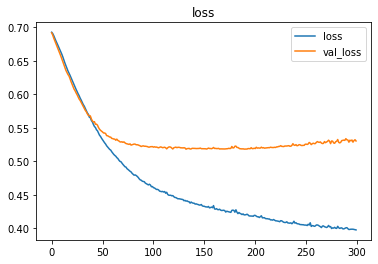

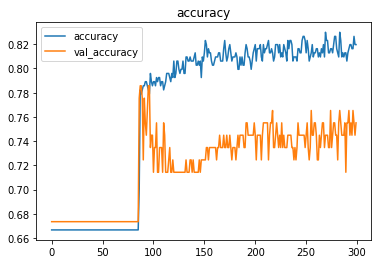

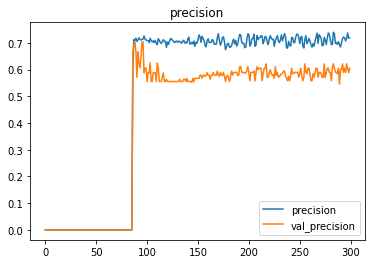

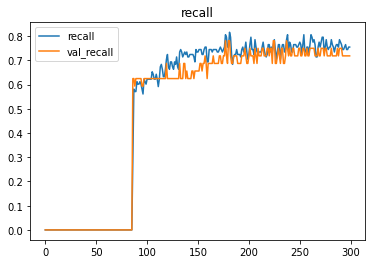

In [28]:
# See how your model is doing
plot_history(history)

## Evaluation

Keras models always output floats, not integers.  In this case the final sigmoid activation function will return a number between 0 and 1.  If the number is closer to 1, the model predicts the sample is more likely to be class 1.  If it is closer to 2, the sample is predicted to be more likely to be class 0.  

This is similar to the output of .predict_proba() with Scikit-Learn models.

### Converting Floats to Ints

In order to use Scikit-Learn metrics functions, the float outputs of the model need to be converted to ints.  We don't want to just use `int(pred)` or `pred.astype(int)` because that will just drop the decimal and all our predictions would be 0s.  

Instead we want to **round** the predictions to the nearest integer. To round all of the numbers in an array we can use the NumPy function, `np.rint()` which is short for 'round to integer'.  

In [29]:
class_model.predict(X_train)[:10]

array([[0.01751196],
       [0.6781917 ],
       [0.6781917 ],
       [0.6781917 ],
       [0.02358648],
       [0.48627853],
       [0.05750111],
       [0.28984734],
       [0.6781917 ],
       [0.6781917 ]], dtype=float32)

In [30]:
# Get predictions
train_pred_proba = class_model.predict(X_train)
test_pred_proba = class_model.predict(X_test)

# round predictions to integers instead of floats
train_preds = np.rint(train_pred_proba)
test_preds = np.rint(test_pred_proba)

# the following code should show whole number predictions, 1.0 or 0.0
print(test_preds[:5])
print(train_preds[:5])

[[0.]
 [1.]
 [1.]
 [1.]
 [0.]]
[[0.]
 [1.]
 [1.]
 [1.]
 [0.]]


base_class_model_train 

              precision    recall  f1-score   support

 No Diabetes       0.88      0.86      0.87       196
    Diabetes       0.73      0.76      0.74        98

    accuracy                           0.82       294
   macro avg       0.80      0.81      0.80       294
weighted avg       0.83      0.82      0.82       294



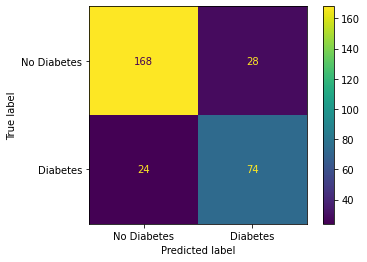

base_class_model_test 

              precision    recall  f1-score   support

 No Diabetes       0.85      0.77      0.81        66
    Diabetes       0.61      0.72      0.66        32

    accuracy                           0.76        98
   macro avg       0.73      0.75      0.73        98
weighted avg       0.77      0.76      0.76        98



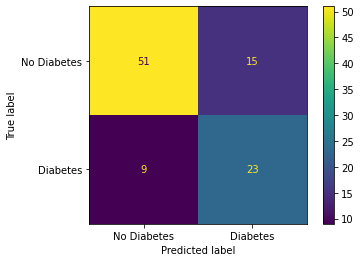

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
base_class_model_train,0.725490,0.755102,0.740000,0.823129
base_class_model_test,0.605263,0.718750,0.657143,0.755102


In [31]:
# Define labels for the confusion matrix
labels = ['No Diabetes', 'Diabetes']

train_scores = eval_classification(y_train, train_preds, 
                                   name='base_class_model_train',
                                  labels=labels)
test_scores = eval_classification(y_test, test_preds, 
                                   name='base_class_model_test',
                                  labels=labels)
class_scores = pd.concat([train_scores, test_scores])
class_scores